<a href="https://colab.research.google.com/github/sborah53/Machine-Learning-for-Physical-Sciences/blob/main/MLPS_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression: Classical 1D Ising Model


In a classical 1D Ising model, each spin $s_i \in \{-1,+1\}$ interacts with its neighbors via the Hamiltonian  
$$
H = -J \sum_{\langle i,j\rangle} s_i s_j,
$$
where $J>0$ corresponds to a ferromagnetic coupling that energetically favors aligned spins. At inverse temperature $\beta$, the probability of a spin configuration is given by the Boltzmann distribution $p(\{s_i\}) \propto \exp(-\beta H)$. Focusing on a single **central** spin $s_i$, the only relevant contribution to its local energy comes from the sum of its neighboring spins $h_i = \sum_{j \in \text{neighbors}} s_j$.

For fixed neighbors, the energy of the central spin takes two possible values,
$$
E_{\text{up}} = E(s_i=+1) = -J h_i,
\qquad
E_{\text{down}} = E(s_i=-1) = +J h_i,
$$
so that the energy gap controlling the local thermal statistics is
$$
\Delta E = E_{\text{down}} - E_{\text{up}} = 2J h_i.
$$
The conditional probability that the central spin is up, given its neighbors, is then
$$
P(s_i = +1 \mid h_i)
= \frac{\exp(-\beta E_{\text{up}})}{\exp(-\beta E_{\text{up}}) + \exp(-\beta E_{\text{down}})}
= \sigma\!\big(\beta \Delta E\big)
= \sigma\!\big(2\beta J\, h_i\big),
$$
where $\sigma(z) = 1/(1+\mathrm{e}^{-z})$ is the logistic sigmoid. If we now regard the local field $x := h_i = \sum_{j} s_j$ as an input feature and fit a one–dimensional logistic regression model
$$
P(y=1 \mid x) = \sigma(\theta x),
$$
the learned slope $\theta$ provides a direct estimate of the physical parameter combination
$$
\theta \approx 2\beta J.
$$
Thus, by training a logistic classifier on spin snapshots $(x, s_i)$, we can infer the coupling strength $J$ and/or effective inverse temperature $\beta$ of the underlying Ising system from data.

True Physics Parameters: J=1.0, beta=0.75
Expected Regression Slope (2*beta*J): 1.5000
Learned Slope (w): 1.3858
Learned Bias (b): 0.0711 (Should be close to 0 for Ising with B=0)


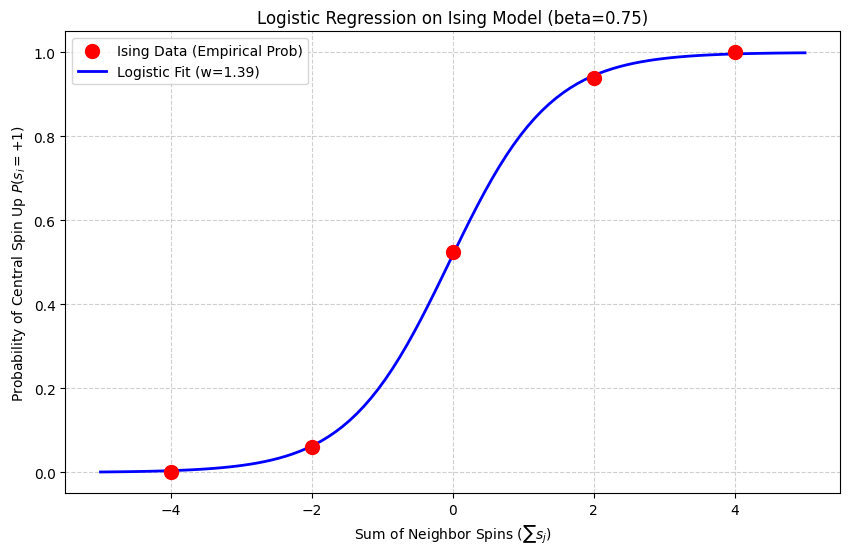

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegressionPhysics:
    """
    Logistic Regression implementation from scratch.
    Models the probability P(y=1|x) = sigmoid(w.x + b).
    """
    def __init__(self, learning_rate=0.01, n_iterations=2000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.costs = []

    def sigmoid(self, z):
        # Clip z to avoid overflow in exp
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.n_iterations):
            # 1. Forward Pass
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            # 2. Cost Calculation (Cross-Entropy)
            # Add epsilon to log to prevent log(0)
            epsilon = 1e-15
            y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
            cost = - (1/n_samples) * np.sum(y * np.log(y_pred_clipped) + (1-y) * np.log(1-y_pred_clipped))
            self.costs.append(cost)

            # 3. Backward Pass (Gradients)
            # dL/dw = (1/m) * X.T * (A - Y)
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # 4. Update Parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X):
        # Threshold at 0.5
        y_pred_probs = self.predict_proba(X)
        return [1 if p > 0.5 else 0 for p in y_pred_probs]

def generate_ising_data(J=1.0, beta=0.5, n_samples=500):
    """
    Generates synthetic data representing a central spin interacting
    with 4 neighbors in a 2D lattice (or just neighbors in general).

    Physics:
    P(s_i = +1) = sigmoid(2 * beta * J * sum(s_neighbors))
    """
    np.random.seed(42)

    # Features: Random states of 4 neighbors (+1 or -1)
    # We map -1 to 0 for the logistic regression input if we want binary features,
    # OR we can keep them as +/-1 sum. Let's use the sum of neighbor spins.

    # Let's say we have 4 neighbors
    neighbors = np.random.choice([-1, 1], size=(n_samples, 4))

    # X feature: Sum of neighbor spins (Local Field proxy)
    X = np.sum(neighbors, axis=1).reshape(-1, 1)

    # Calculate True Physics Probability
    # Delta E = 2 * J * (sum s_j)
    # Argument to sigmoid is beta * Delta E = 2 * beta * J * X
    true_argument = 2 * beta * J * X.flatten()
    probabilities = 1 / (1 + np.exp(-true_argument))

    # Sample actual states (y) based on these probabilities
    y = np.array([np.random.choice([1, 0], p=[p, 1-p]) for p in probabilities])

    return X, y, (2 * beta * J)

if __name__ == "__main__":
    # 1. Physics Parameters
    J_true = 1.0
    beta_true = 0.75
    expected_slope = 2 * beta_true * J_true
    print(f"True Physics Parameters: J={J_true}, beta={beta_true}")
    print(f"Expected Regression Slope (2*beta*J): {expected_slope:.4f}")

    # 2. Generate Data
    X, y, true_coeff = generate_ising_data(J=J_true, beta=beta_true, n_samples=1000)

    # 3. Train Custom Model
    model = LogisticRegressionPhysics(learning_rate=0.1, n_iterations=5000)
    model.fit(X, y)

    print(f"Learned Slope (w): {model.weights[0]:.4f}")
    print(f"Learned Bias (b): {model.bias:.4f} (Should be close to 0 for Ising with B=0)")

    # 4. Visualization
    plt.figure(figsize=(10, 6))

    # Plot Data (Binned for probability visualization)
    # We plot the fraction of UP spins for each unique neighbor sum value
    unique_fields = np.unique(X)
    probs_empirical = []
    for field in unique_fields:
        mask = (X.flatten() == field)
        probs_empirical.append(np.mean(y[mask]))

    plt.scatter(unique_fields, probs_empirical, color='red', s=100, label='Ising Data (Empirical Prob)', zorder=5)

    # Plot Model Curve
    x_range = np.linspace(X.min()-1, X.max()+1, 100).reshape(-1, 1)
    y_model = model.predict_proba(x_range)

    plt.plot(x_range, y_model, color='blue', linewidth=2, label=f'Logistic Fit (w={model.weights[0]:.2f})')

    plt.title(f"Logistic Regression on Ising Model (beta={beta_true})")
    plt.xlabel(r"Sum of Neighbor Spins ($\sum s_j$)")
    plt.ylabel(r"Probability of Central Spin Up $P(s_i=+1)$")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Learned Slope: 1.3858
Learned Bias: 0.0711


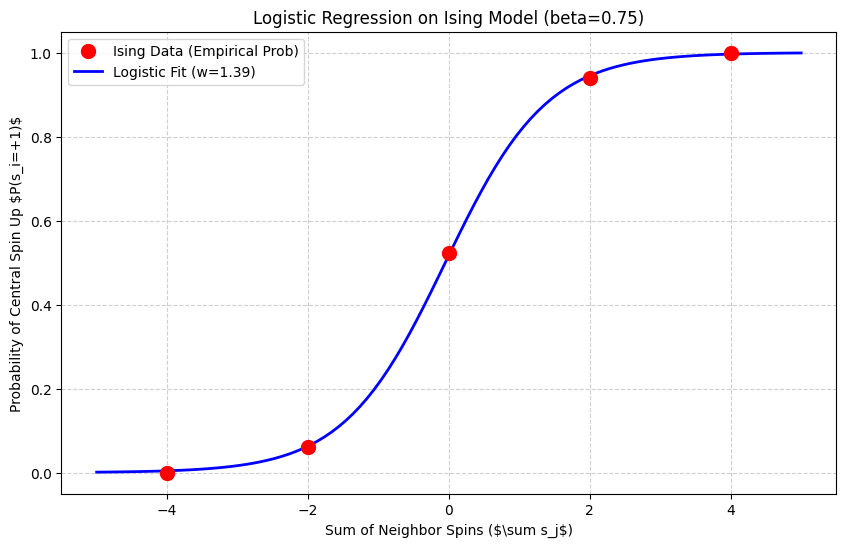

In [5]:
from sklearn.linear_model import LogisticRegression
# sklearn applies regularization by default (C=1.0).
# We set penalty=None to match our unregularized scratch implementation.
sk_model = LogisticRegression(penalty=None, solver='lbfgs')
sk_model.fit(X, y)
print(f"Learned Slope: {sk_model.coef_[0][0]:.4f}")
print(f"Learned Bias: {sk_model.intercept_[0]:.4f}")


plt.figure(figsize=(10, 6))
plt.scatter(unique_fields, probs_empirical, color='red', s=100,
            label='Ising Data (Empirical Prob)', zorder=5)

x_range = np.linspace(X.min()-1, X.max()+1, 100).reshape(-1, 1)
y_model = model.predict_proba(x_range)

plt.plot(x_range, y_model, color='blue', linewidth=2,
         label=f'Logistic Fit (w={model.weights[0]:.2f})')

# Note the raw string r"" but with \$ to escape the dollar signs
plt.title(f"Logistic Regression on Ising Model (beta={beta_true})")
plt.xlabel(r"Sum of Neighbor Spins (\$\sum s_j\$)")
plt.ylabel(r"Probability of Central Spin Up \$P(s_i=+1)\$")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
